## Install Required Libraries

In [ ]:
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 5.6 MB/s eta 0:00:00


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.8/883.8 kB 15.1 MB/s eta 0:00:00


## Import Required Libraries

In [ ]:
import os
import json
import torch
import torchvision
import requests
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
from tqdm.notebook import tqdm
from google.colab import drive
import warnings
import torchvision.transforms as T
from torchvision.transforms import functional as F
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import random
from tqdm.notebook import tqdm
from ultralytics import YOLO
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Mounted at /content/drive


In [ ]:
PROJECT_DIR = '/content/drive/MyDrive/blood_cell_detection'
os.makedirs(PROJECT_DIR, exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/dataset', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/models', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/results', exist_ok=True)

## Download and Convert BCCD Dataset to COCO Format with Bounding Boxes


--2024-11-11 18:28:18--  https://github.com/Shenggan/BCCD_Dataset/archive/master.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Shenggan/BCCD_Dataset/zip/refs/heads/master [following]
--2024-11-11 18:28:18--  https://codeload.github.com/Shenggan/BCCD_Dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [  <=>               ]   7.56M  29.6MB/s    in 0.3s    

2024-11-11 18:28:19 (29.6 MB/s) - ‘master.zip’ saved [7927884]

Archive:  master.zip
d272fb14cdff6e473fafeeeba32aba5f560e9e43
   creating: BCCD_Dataset-master/
 extracting: BCCD_Dataset-master/.gitignore  
 

  0%|          | 0/364 [00:00<?, ?it/s]


Dataset downloaded and prepared:
Number of images: 364
Number of annotations: 4888

Displaying sample images with bounding boxes:


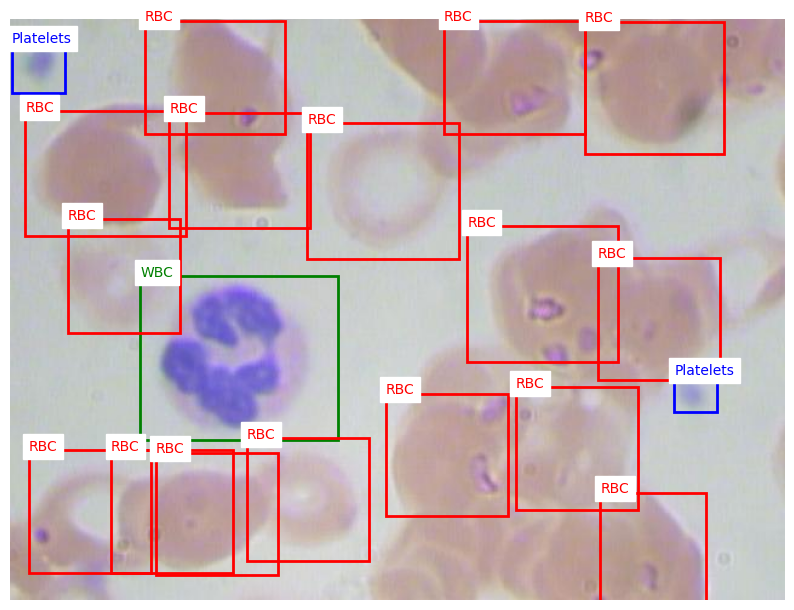

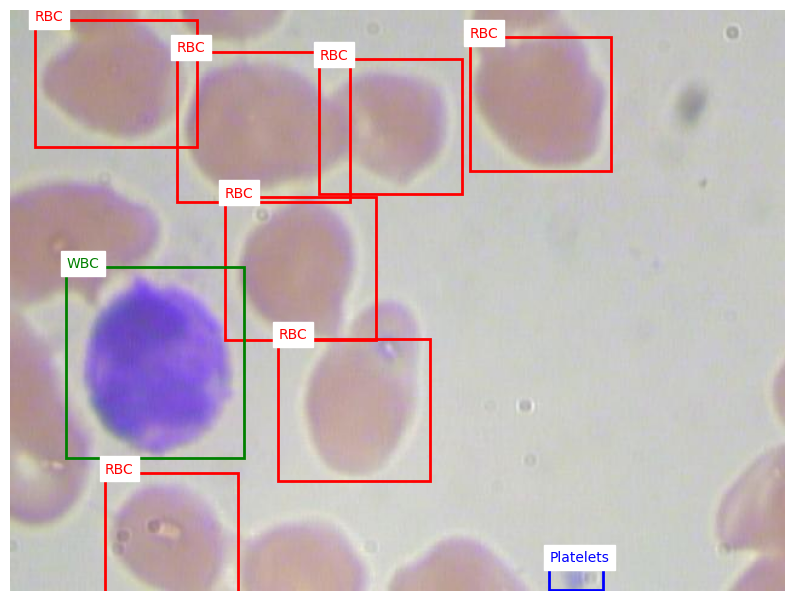

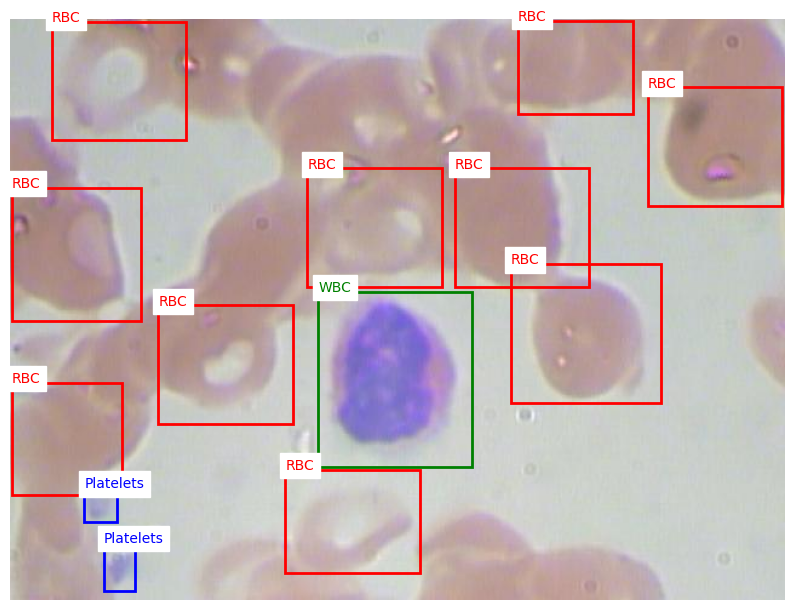


Dataset is ready to use with the object detection model!


In [ ]:
def download_bccd_dataset():
    """
    Download BCCD dataset from GitHub
    """
    print("Downloading BCCD dataset...")

    # Download dataset from GitHub
    !wget https://github.com/Shenggan/BCCD_Dataset/archive/master.zip
    !unzip master.zip

    # Move images and annotations to our directory
    source_dir = '/content/BCCD_Dataset-master/BCCD/JPEGImages'
    annotation_dir = '/content/BCCD_Dataset-master/BCCD/Annotations'

    # Create COCO format dictionary
    coco_dict = {
        "images": [],
        "annotations": [],
        "categories": [
            {"id": 1, "name": "RBC"},
            {"id": 2, "name": "WBC"},
            {"id": 3, "name": "Platelets"}
        ]
    }

    # Process images and annotations
    annotation_id = 1

    print("Converting annotations to COCO format...")
    for idx, filename in enumerate(tqdm(os.listdir(source_dir))):
        if filename.endswith('.jpg'):
            # Copy image
            image_path = os.path.join(source_dir, filename)
            new_image_path = os.path.join('/content/bccd_dataset/images', filename)
            shutil.copy(image_path, new_image_path)

            # Get image dimensions
            with Image.open(image_path) as img:
                width, height = img.size

            # Add image info to COCO dict
            image_info = {
                "id": idx,
                "file_name": filename,
                "width": width,
                "height": height
            }
            coco_dict["images"].append(image_info)

            # Process annotation
            xml_filename = os.path.join(annotation_dir, filename.replace('.jpg', '.xml'))
            if os.path.exists(xml_filename):
                tree = ET.parse(xml_filename)
                root = tree.getroot()

                for obj in root.findall('object'):
                    name = obj.find('name').text
                    # Map class names to category IDs
                    category_map = {'RBC': 1, 'WBC': 2, 'Platelets': 3}
                    category_id = category_map.get(name, 0)

                    if category_id > 0:
                        bndbox = obj.find('bndbox')
                        xmin = float(bndbox.find('xmin').text)
                        ymin = float(bndbox.find('ymin').text)
                        xmax = float(bndbox.find('xmax').text)
                        ymax = float(bndbox.find('ymax').text)

                        # Convert to COCO format [x, y, width, height]
                        width = xmax - xmin
                        height = ymax - ymin

                        annotation_info = {
                            "id": annotation_id,
                            "image_id": idx,
                            "category_id": category_id,
                            "bbox": [xmin, ymin, width, height],
                            "area": width * height,
                            "iscrowd": 0
                        }
                        coco_dict["annotations"].append(annotation_info)
                        annotation_id += 1

    # Save COCO format annotations
    with open('/content/bccd_dataset/annotations/instances.json', 'w') as f:
        json.dump(coco_dict, f)

    print(f"\nDataset downloaded and prepared:")
    print(f"Number of images: {len(coco_dict['images'])}")
    print(f"Number of annotations: {len(coco_dict['annotations'])}")

    # Display sample images with bounding boxes
    def plot_sample(idx=0):
        img_info = coco_dict["images"][idx]
        img_path = f"/content/bccd_dataset/images/{img_info['file_name']}"
        img = Image.open(img_path)

        plt.figure(figsize=(10, 10))
        plt.imshow(img)

        # Plot bounding boxes
        for ann in coco_dict["annotations"]:
            if ann["image_id"] == idx:
                bbox = ann["bbox"]
                category_id = ann["category_id"]
                color = ['r', 'g', 'b'][category_id-1]  # Different color for each class
                rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                                  fill=False, color=color, linewidth=2)
                plt.gca().add_patch(rect)
                plt.text(bbox[0], bbox[1], coco_dict["categories"][category_id-1]["name"],
                        color=color, backgroundcolor="white")

        plt.axis('off')
        plt.show()

    # Show 3 sample images
    print("\nDisplaying sample images with bounding boxes:")
    for i in range(min(3, len(coco_dict["images"]))):
        plot_sample(i)


download_bccd_dataset()


## Define Compose Class


In [ ]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

## Data Augmentation

In [ ]:
class RandomHorizontalFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = F.hflip(image)
            bbox = target["boxes"]

            # Flip boxes
            if len(bbox) > 0:
                bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
                target["boxes"] = bbox

        return image, target

In [ ]:
class ColorJitter:
    def __init__(self, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1):
        self.color_jitter = T.ColorJitter(brightness, contrast, saturation, hue)

    def __call__(self, image, target):
        image = self.color_jitter(image)
        return image, target


In [ ]:
class RandomRotation:
    def __init__(self, degrees=10):
        self.degrees = degrees

    def __call__(self, image, target):
        angle = random.uniform(-self.degrees, self.degrees)
        height, width = image.shape[-2:]
        image = F.rotate(image, angle)

        if len(target["boxes"]) > 0:
            # Convert boxes to points
            boxes = target["boxes"]
            corners = torch.zeros((len(boxes), 4, 2), dtype=torch.float32)  # Specify dtype
            for i, box in enumerate(boxes):
                corners[i] = torch.tensor([
                    [box[0], box[1]], [box[2], box[1]],
                    [box[2], box[3]], [box[0], box[3]]
                ], dtype=torch.float32)  # Specify dtype

            # Rotate points
            center = torch.tensor([[width/2, height/2]], dtype=torch.float32)  # Specify dtype
            angle_rad = -angle * np.pi / 180
            rot_mat = torch.tensor([
                [np.cos(angle_rad), -np.sin(angle_rad)],
                [np.sin(angle_rad), np.cos(angle_rad)]
            ], dtype=torch.float32)  # Specify dtype

            corners = corners - center
            corners = torch.matmul(corners, rot_mat.T)
            corners = corners + center

            # Get new bounding boxes
            new_boxes = torch.zeros_like(boxes)
            for i, corner in enumerate(corners):
                new_boxes[i, 0] = corner[:, 0].min()
                new_boxes[i, 1] = corner[:, 1].min()
                new_boxes[i, 2] = corner[:, 0].max()
                new_boxes[i, 3] = corner[:, 1].max()

            target["boxes"] = new_boxes

        return image, target


In [ ]:
class RandomCrop:
    def __init__(self, min_size=600):
        self.min_size = min_size

    def __call__(self, image, target):
        height, width = image.shape[-2:]

        # Ensure crop size doesn't exceed image dimensions
        h_crop = min(height, random.randint(self.min_size, height))
        w_crop = min(width, random.randint(self.min_size, width))

        # Ensure starting position is valid
        i = random.randint(0, max(0, height - h_crop))
        j = random.randint(0, max(0, width - w_crop))

        image = F.crop(image, i, j, h_crop, w_crop)

        if len(target["boxes"]) > 0:
            boxes = target["boxes"]

            # Adjust boxes
            boxes[:, [0, 2]] = boxes[:, [0, 2]] - j
            boxes[:, [1, 3]] = boxes[:, [1, 3]] - i

            # Clip boxes
            boxes[:, [0, 2]] = boxes[:, [0, 2]].clamp(0, w_crop)
            boxes[:, [1, 3]] = boxes[:, [1, 3]].clamp(0, h_crop)

            # Remove invalid boxes
            keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
            target["boxes"] = boxes[keep]
            if "labels" in target:
                target["labels"] = target["labels"][keep]

        return image, target

## Define Transformation Pipeline


In [ ]:
def get_transform(train=True):
    """
    Get the transformation pipeline for training or validation
    """
    transforms = []
    transforms.append(T.ToTensor())

    if train:
        transforms.extend([
            RandomHorizontalFlip(0.5),
            RandomRotation(10),
            ColorJitter(0.2, 0.2, 0.2, 0.1),
            RandomCrop(400)  # Adjusted default crop size
        ])

    return Compose(transforms)

## Calculate COCO Metrics for Model Evaluation


In [ ]:
def calculate_metrics(model, data_loader, device, iou_threshold=0.5):
    model.eval()

    # Initialize COCO format datasets
    coco_gt = {
        "images": [],
        "annotations": [],
        "categories": [
            {"id": 1, "name": "RBC"},
            {"id": 2, "name": "WBC"},
            {"id": 3, "name": "Platelets"}
        ]
    }

    coco_dt = []

    img_id = 0
    ann_id = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]

            # Process ground truth
            for target in targets:
                # Add image info
                coco_gt["images"].append({
                    "id": img_id,
                    "width": 800,  # Adjust if your images have different dimensions
                    "height": 800
                })

                # Add ground truth annotations
                boxes = target["boxes"].cpu().numpy()
                labels = target["labels"].cpu().numpy()

                for box, label in zip(boxes, labels):
                    x1, y1, x2, y2 = box
                    width = x2 - x1
                    height = y2 - y1

                    coco_gt["annotations"].append({
                        "id": ann_id,
                        "image_id": img_id,
                        "category_id": int(label),
                        "bbox": [x1, y1, width, height],
                        "area": width * height,
                        "iscrowd": 0
                    })
                    ann_id += 1

                # Get predictions
                predictions = model(images)

                # Process predictions for current image
                pred = predictions[0]  # Get prediction for current image
                pred_boxes = pred["boxes"].cpu().numpy()
                pred_scores = pred["scores"].cpu().numpy()
                pred_labels = pred["labels"].cpu().numpy()

                # Add predictions to detection list
                for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
                    x1, y1, x2, y2 = box
                    width = x2 - x1
                    height = y2 - y1

                    coco_dt.append({
                        "image_id": img_id,
                        "category_id": int(label),
                        "bbox": [x1, y1, width, height],
                        "score": float(score),
                    })

                img_id += 1



    # Create ground truth COCO object
    gt_coco = COCO()
    gt_coco.dataset = coco_gt
    gt_coco.createIndex()

    # Create detection COCO object
    dt_coco = gt_coco.loadRes(coco_dt)

    # Create COCO evaluator
    cocoEval = COCOeval(gt_coco, dt_coco, 'bbox')
    cocoEval.params.iouThrs = [iou_threshold]  # Set IoU threshold

    # Run evaluation
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

    # Return metrics
    return {
        'AP': cocoEval.stats[0],  # AP at IoU=.50:.05:.95
        'AP50': cocoEval.stats[1],  # AP at IoU=.50
        'AP75': cocoEval.stats[2],  # AP at IoU=.75
        'APs': cocoEval.stats[3],   # AP for small objects
        'APm': cocoEval.stats[4],   # AP for medium objects
        'APl': cocoEval.stats[5]    # AP for large objects
    }


## Visualize Augmentations


In [ ]:
def visualize_augmentations(dataset, save_dir):
    """
    Visualize different augmentations applied to a single image from the dataset
    """
    # Get one image and its target
    image, target = dataset[0]

    # Convert PIL image to tensor if it's not already
    if not isinstance(image, torch.Tensor):
        to_tensor = T.ToTensor()
        image = to_tensor(image)

    # Define augmentations to visualize with smaller rotation angle and adjusted crop size
    augmentations = {
        'Original': lambda img, tgt: (img, tgt),
        'Horizontal Flip': lambda img, tgt: RandomHorizontalFlip(1.0)(img, tgt.copy()),
        'Rotation': lambda img, tgt: RandomRotation(15)(img, tgt.copy()),  # Reduced angle
        'Color Jitter': lambda img, tgt: ColorJitter(0.5, 0.5, 0.5, 0.2)(img, tgt.copy()),
        'Random Crop': lambda img, tgt: RandomCrop(min(400, min(img.shape[-2:])))(img, tgt.copy())  # Adjusted crop size
    }

    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Create figure
    fig, axes = plt.subplots(1, len(augmentations), figsize=(20, 4))

    for idx, (name, transform_fn) in enumerate(augmentations.items()):
        try:
            # Apply transformation
            aug_image, aug_target = transform_fn(image, target)

            # Convert to PIL for visualization
            img_show = F.to_pil_image(aug_image)

            # Plot image
            axes[idx].imshow(img_show)
            axes[idx].set_title(name)

            # Draw bounding boxes
            if 'boxes' in aug_target and len(aug_target['boxes']) > 0:
                for box in aug_target['boxes']:
                    box = box.numpy() if isinstance(box, torch.Tensor) else box
                    rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                       fill=False, color='red', linewidth=2)
                    axes[idx].add_patch(rect)

            axes[idx].axis('off')

        except Exception as e:
            print(f"Error applying {name} transformation: {str(e)}")
            # Plot empty subplot in case of error
            axes[idx].text(0.5, 0.5, f"Error: {name}", ha='center', va='center')
            axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'augmentation_samples.png'))
    plt.close()

## BCCDDataset Class to Load and Process BCCD Data in COCO Format


In [ ]:
class BCCDDataset(Dataset):
    def __init__(self, root_dir, coco_json, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        with open(coco_json, 'r') as f:
            self.coco_data = json.load(f)

        self.images = self.coco_data['images']
        self.annotations = self.coco_data['annotations']

        self.img_to_anns = {}
        for ann in self.annotations:
            img_id = ann['image_id']
            if img_id not in self.img_to_anns:
                self.img_to_anns[img_id] = []
            self.img_to_anns[img_id].append(ann)

    def _validate_box(self, bbox):
        """Validate and fix bounding box coordinates"""
        x1, y1, w, h = bbox

        # Ensure positive width and height
        w = max(1.0, w)  # Minimum width of 1 pixel
        h = max(1.0, h)  # Minimum height of 1 pixel

        return [x1, y1, w, h]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')

        img_id = img_info['id']
        boxes = []
        labels = []

        if img_id in self.img_to_anns:
            for ann in self.img_to_anns[img_id]:
                # Validate and fix bbox
                bbox = self._validate_box(ann['bbox'])

                # Convert from [x, y, width, height] to [x1, y1, x2, y2] format
                boxes.append([
                    bbox[0],
                    bbox[1],
                    bbox[0] + bbox[2],
                    bbox[1] + bbox[3]
                ])
                labels.append(ann['category_id'])

        # Handle empty boxes
        if not boxes:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }

        if self.transform:
            image = self.transform(image)

        return image, target

## Helper Functions for Data Transformations, Model Initialization, and Training Loop

In [ ]:
def get_transform(train):
    transforms_list = []
    transforms_list.append(transforms.ToTensor())
    if train:
        transforms_list.append(transforms.RandomHorizontalFlip(0.5))
    return transforms.Compose(transforms_list)

In [ ]:
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0

    for images, targets in tqdm(data_loader, desc="Training"):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    return total_loss / len(data_loader)

## Evaluation Function

In [ ]:
def evaluate(model, data_loader, device):
    """Evaluate the model on the validation set"""
    model.train()  # Set to train mode to get losses
    total_loss = 0

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating"):
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Ensure model is in training mode to get losses
            loss_dict = model(images, targets)

            # Calculate total loss
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()

    avg_loss = total_loss / len(data_loader)
    return avg_loss

In [ ]:
def visualize_and_save(model, dataset, device, num_images=5):
    """Visualize model predictions and save results"""
    model.eval()  # Ensure model is in evaluation mode
    figure, axes = plt.subplots(num_images, 2, figsize=(20, 5*num_images))

    try:
        for idx in range(min(num_images, len(dataset))):
            image, target = dataset[idx]

            # Original image with ground truth
            axes[idx, 0].imshow(transforms.ToPILImage()(image))
            for box in target['boxes']:
                box = box.numpy()
                rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                   fill=False, color='green')
                axes[idx, 0].add_patch(rect)
            axes[idx, 0].set_title('Ground Truth')
            axes[idx, 0].axis('off')

            # Predictions
            with torch.no_grad():
                prediction = model([image.to(device)])
                prediction = prediction[0]

            axes[idx, 1].imshow(transforms.ToPILImage()(image))
            if len(prediction['boxes']) > 0:  # Check if any predictions exist
                for box, score in zip(prediction['boxes'], prediction['scores']):
                    if score > 0.5:  # Confidence threshold
                        box = box.cpu().numpy()
                        rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                           fill=False, color='red')
                        axes[idx, 1].add_patch(rect)
                        axes[idx, 1].text(box[0], box[1], f'{score:.2f}', color='red',
                                        backgroundcolor='white')
            axes[idx, 1].set_title('Predictions')
            axes[idx, 1].axis('off')

        plt.tight_layout()
        # Save figure
        plt.savefig(f'{PROJECT_DIR}/results/predictions.png')
        plt.close()

    except Exception as e:
        print(f"An error occurred during visualization: {str(e)}")
        plt.close()
        raise e

## Main function

In [ ]:
def main():
    # Parameters
    num_classes = 4  # 3 classes + background
    num_epochs = 5
    batch_size = 4
    learning_rate = 0.005

    # Setup device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print(f"Using device: {device}")

    # # Download and prepare dataset
    # coco_dict = download_bccd_dataset()

    dataset = BCCDDataset(
        root_dir=f'{PROJECT_DIR}/dataset/images',
        coco_json=f'{PROJECT_DIR}/dataset/annotations/instances.json',
        transform=get_transform(train=True)
    )
    visualize_augmentations(dataset, f'{PROJECT_DIR}/results')

    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    dataset_train, dataset_val = torch.utils.data.random_split(dataset, [train_size, val_size])

    # Create data loaders
    data_loader_train = DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True,
        collate_fn=lambda x: tuple(zip(*x))
    )
    data_loader_val = DataLoader(
        dataset_val, batch_size=batch_size, shuffle=False,
        collate_fn=lambda x: tuple(zip(*x))
    )

    # Create model
    model = get_model(num_classes)
    model.to(device)

    # Create optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)

    # Training loop
    print("Starting training...")
    train_losses = []
    val_losses = []

    try:
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")

            # Train
            model.train()
            train_loss = train_one_epoch(model, optimizer, data_loader_train, device)
            train_losses.append(train_loss)

            # Validate
            model.train()  # Keep in train mode for validation to get losses
            val_loss = evaluate(model, data_loader_val, device)
            val_losses.append(val_loss)

            print(f"Training Loss: {train_loss:.4f}")
            print(f"Validation Loss: {val_loss:.4f}")

            # Save checkpoint
            checkpoint_path = f'{PROJECT_DIR}/models/checkpoint_epoch_{epoch+1}.pth'
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, checkpoint_path)

        # Save final model
        torch.save(model.state_dict(), f'{PROJECT_DIR}/models/final_model.pth')

        # Plot training curves
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Losses')
        plt.savefig(f'{PROJECT_DIR}/results/training_curves.png')
        plt.show()

        metrics = calculate_metrics(model, data_loader_val, device)
        with open(f'{PROJECT_DIR}/results/metrics.json', 'w') as f:
             json.dump(metrics, f, indent=4)

        plt.figure(figsize=(10, 6))
        plt.bar(metrics.keys(), metrics.values())
        plt.title('Detection Metrics')
        plt.ylabel('Score')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f'{PROJECT_DIR}/results/metrics.png')
        plt.close()


        # Save training history
        history = {
            'train_losses': train_losses,
            'val_losses': val_losses
        }
        with open(f'{PROJECT_DIR}/results/training_history.json', 'w') as f:
            json.dump(history, f)

        # Create predictions visualization
        print("\nVisualizing predictions...")
        model.eval()  # Set to eval mode for predictions
        visualize_and_save(model, dataset_val, device)

    except Exception as e:
        print(f"An error occurred during training: {str(e)}")
        raise e


if __name__ == "__main__":
    # Install required packages
    !pip install torch torchvision tqdm
    main()

In [ ]:
def main():
    # Parameters
    num_classes = 4  # 3 classes + background
    num_epochs = 10 # Increase the number of epochs
    batch_size = 4
    learning_rate = 0.005

    # Setup device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print(f"Using device: {device}")

    # Load dataset
    dataset = BCCDDataset(
        root_dir=f'{PROJECT_DIR}/dataset/images',
        coco_json=f'{PROJECT_DIR}/dataset/annotations/instances.json',
        transform=get_transform(train=True)
    )

    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    dataset_train, dataset_val = torch.utils.data.random_split(dataset, [train_size, val_size])

    # Create data loaders
    data_loader_train = DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True,
        collate_fn=lambda x: tuple(zip(*x))
    )
    data_loader_val = DataLoader(
        dataset_val, batch_size=batch_size, shuffle=False,
        collate_fn=lambda x: tuple(zip(*x))
    )

    # Create model
    model = get_model(num_classes)
    model.to(device)

    # Create optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)

    # Load checkpoint if available
    start_epoch = 6
    checkpoint_path = f'{PROJECT_DIR}/models/checkpoint_epoch_6.pth'
    if os.path.exists(checkpoint_path):
        print("Loading checkpoint...")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resuming training from epoch {start_epoch}")

    # Training loop
    print("Starting/Continuing training...")
    train_losses = []
    val_losses = []

    for epoch in range(start_epoch, num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Train
        model.train()
        train_loss = train_one_epoch(model, optimizer, data_loader_train, device)
        train_losses.append(train_loss)

        # Validate
        model.train()  # Keep in train mode for validation to get losses
        val_loss = evaluate(model, data_loader_val, device)
        val_losses.append(val_loss)

        print(f"Training Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")

        # Save checkpoint
        checkpoint_path = f'{PROJECT_DIR}/models/checkpoint_epoch_{epoch+1}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, checkpoint_path)

        # Save latest checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, f'{PROJECT_DIR}/models/checkpoint_epoch_latest.pth')

    # Save final model
    torch.save(model.state_dict(), f'{PROJECT_DIR}/models/final_model.pth')


    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses')
    plt.savefig(f'{PROJECT_DIR}/new_results/training_curves.png')
    plt.show()

    metrics = calculate_metrics(model, data_loader_val, device)
    with open(f'{PROJECT_DIR}/new_results/metrics.json', 'w') as f:
        json.dump(metrics, f, indent=4)

    plt.figure(figsize=(10, 6))
    plt.bar(metrics.keys(), metrics.values())
    plt.title('Detection Metrics')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{PROJECT_DIR}/new_results/metrics.png')
    plt.close()

    # Save training history
    history = {
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    with open(f'{PROJECT_DIR}/new_results/training_history.json', 'w') as f:
        json.dump(history, f)

    # Create predictions visualization
    print("\nVisualizing predictions...")
    model.eval()  # Set to eval mode for predictions
    visualize_and_save(model, dataset_val, device)

Using device: cpu
Loading checkpoint...
Resuming training from epoch 6
Starting/Continuing training...

Epoch 7/10


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 0.9724
Validation Loss: 1.0331

Epoch 8/10


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 0.9036
Validation Loss: 0.8668

Epoch 9/10


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 0.9053
Validation Loss: 0.9162

Epoch 10/10


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 0.9561
Validation Loss: 0.9496


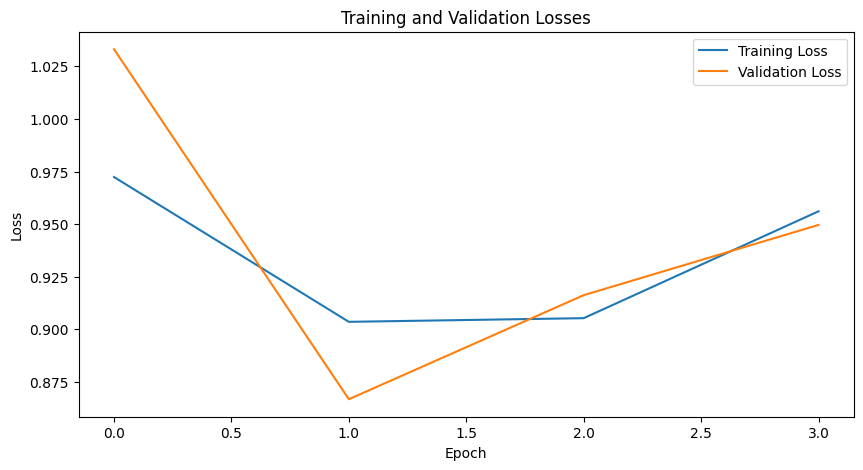

creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.24s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.50 | area=   all | maxDets=100 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.50 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.50 | area=medium | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.50 | area= large | maxDets=100 ] = 0.120
 Average Recall     (AR) @[ IoU=0.50:0.50 | area=   all | maxDets=  1 ] = 0.099
 Average Recall     (AR) @[ IoU=0.50:0.50 | area=   all | maxDets= 10 ] = 0.197
 Average Recall     (AR) @[ IoU=0.50:0.50 | area=   all | maxDets=100 ] = 0.334
 Average Recall     (AR) @[ IoU=0

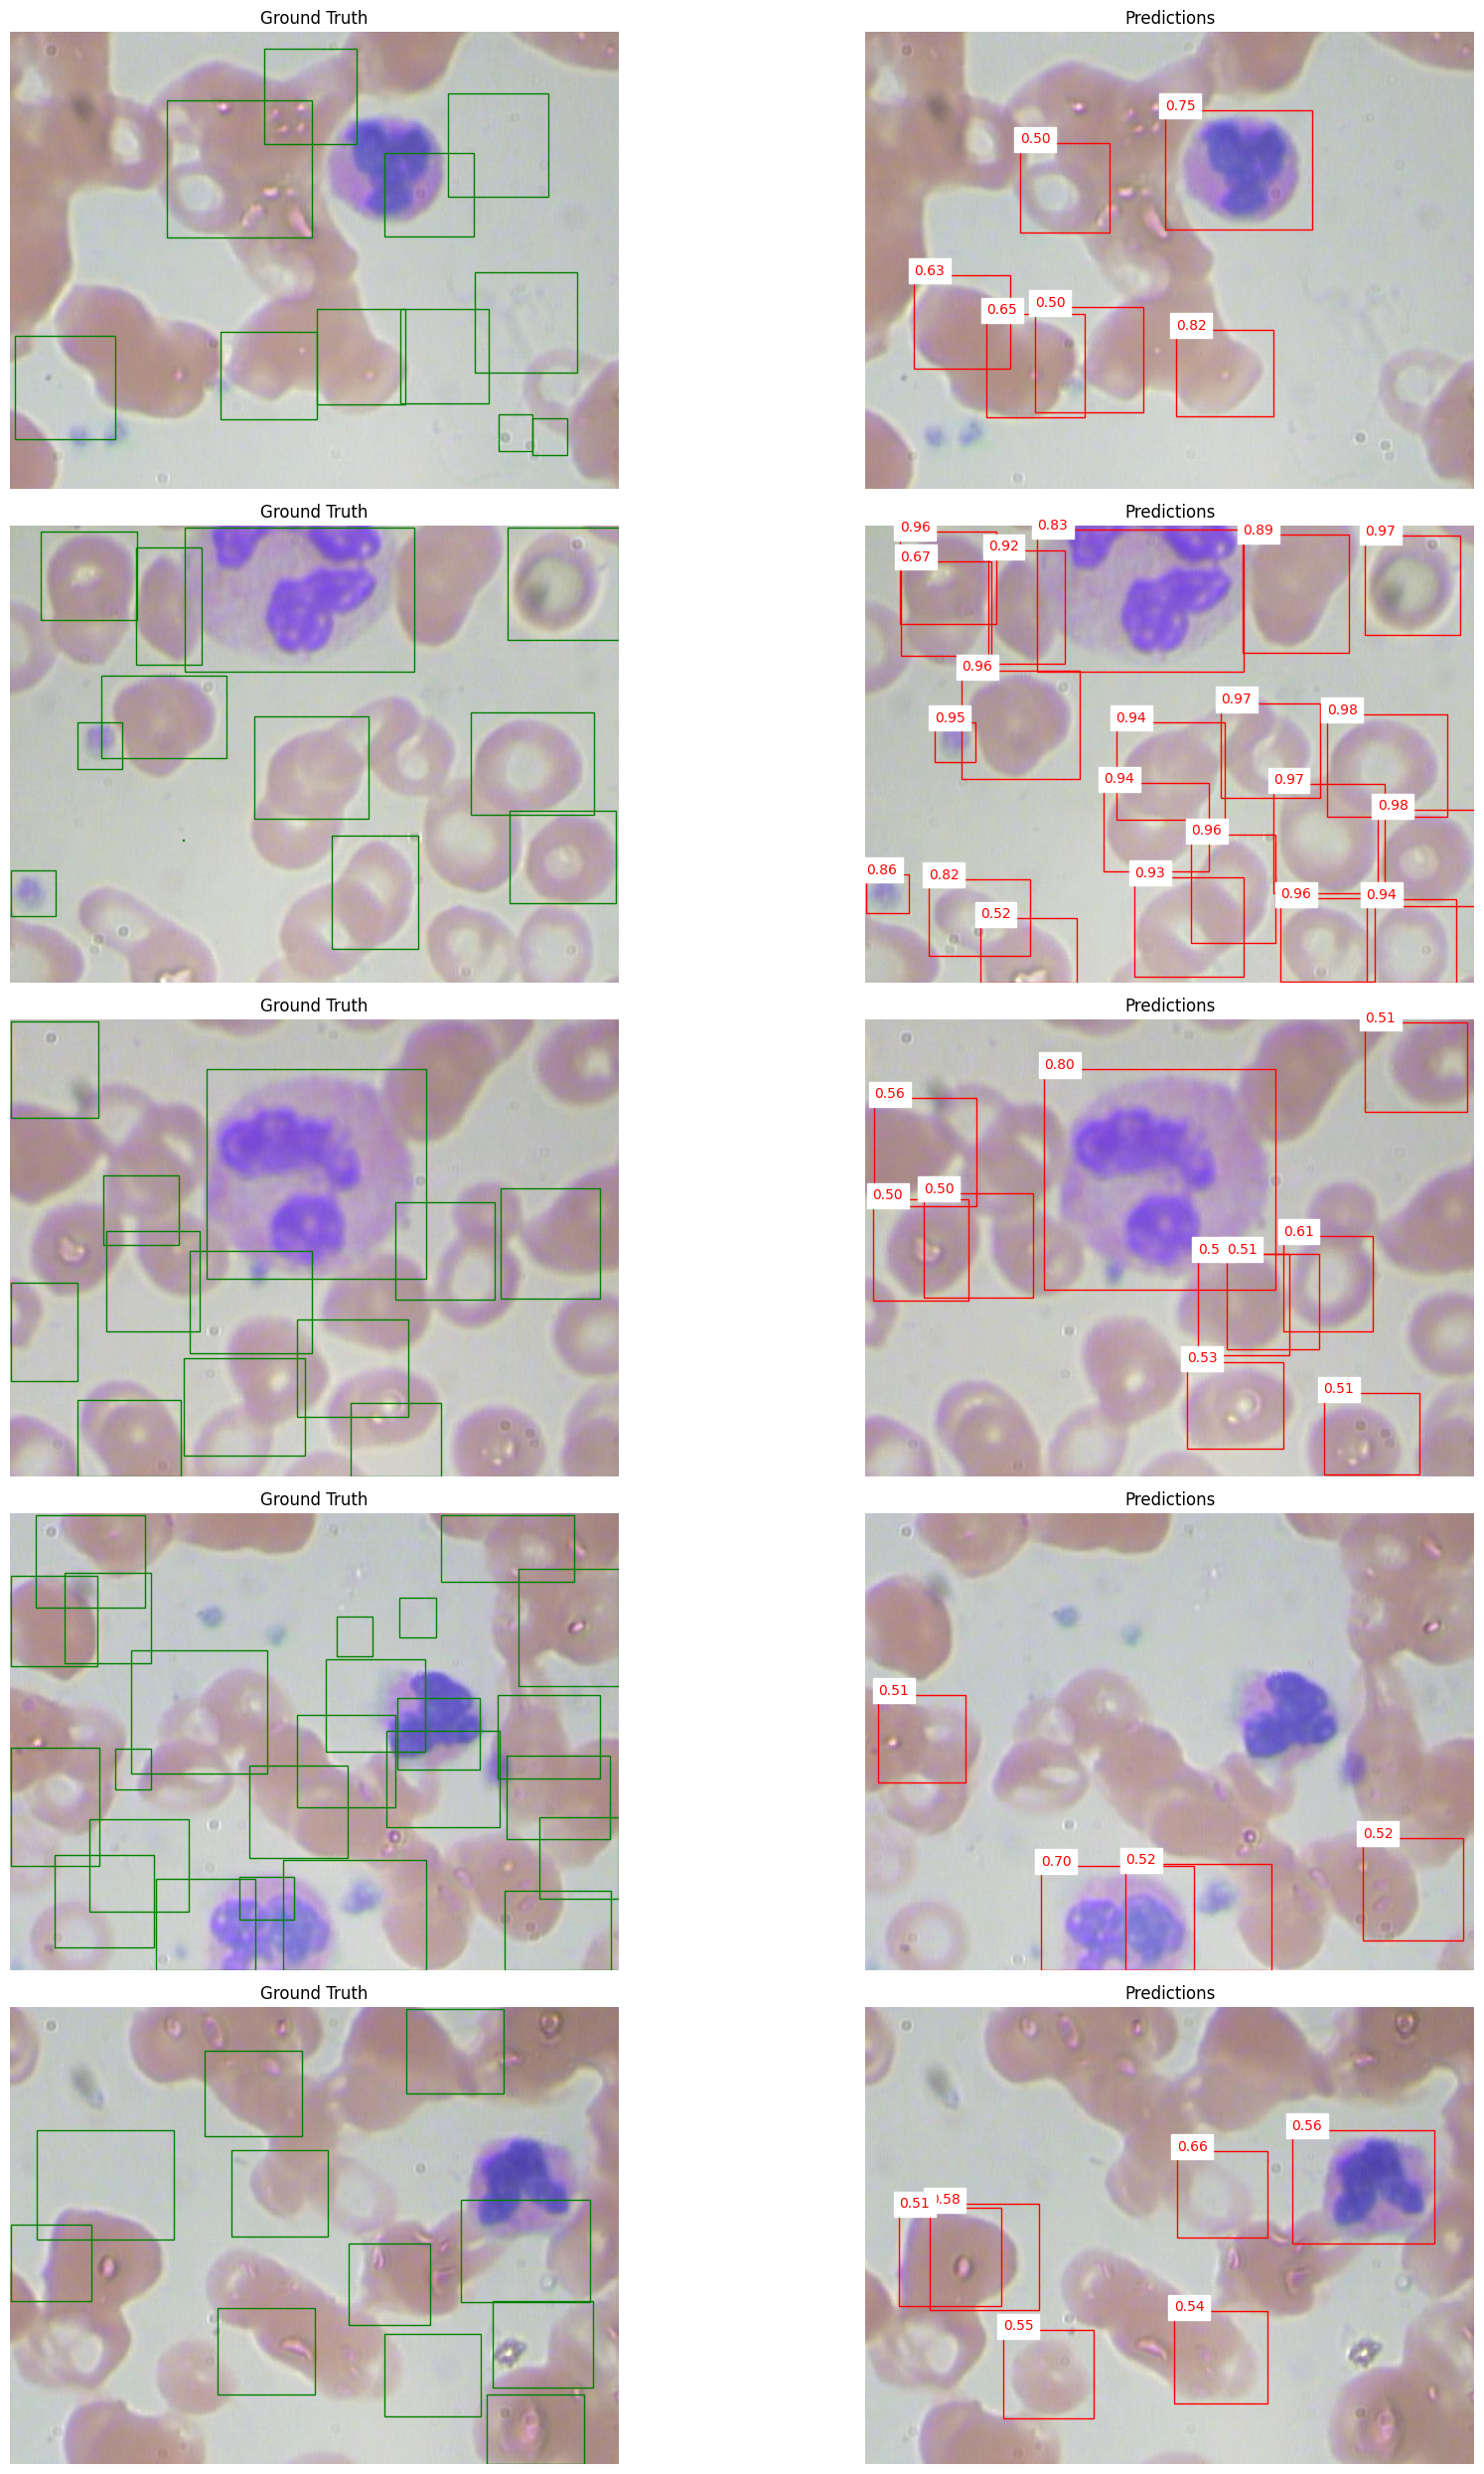

In [ ]:
if __name__ == "__main__":
    # Install required packages
    !pip install torch torchvision tqdm
    main()

## YOLO

In [ ]:
BETTER_RESULTS_DIR = f'{PROJECT_DIR}/yolo_results'

os.makedirs(BETTER_RESULTS_DIR, exist_ok=True)
os.makedirs(f'{BETTER_RESULTS_DIR}/dataset', exist_ok=True)
os.makedirs(f'{BETTER_RESULTS_DIR}/models', exist_ok=True)
os.makedirs(f'{BETTER_RESULTS_DIR}/results', exist_ok=True)

In [ ]:
def convert_to_yolo_format(source_dir, annotation_dir, output_dir):
    """
    Convert BCCD dataset to YOLO format
    """
    # Create directories
    os.makedirs(f'{output_dir}/images/train', exist_ok=True)
    os.makedirs(f'{output_dir}/images/val', exist_ok=True)
    os.makedirs(f'{output_dir}/labels/train', exist_ok=True)
    os.makedirs(f'{output_dir}/labels/val', exist_ok=True)

    # Class mapping
    class_map = {'RBC': 0, 'WBC': 1, 'Platelets': 2}

    image_files = [f for f in os.listdir(source_dir) if f.endswith('.jpg')]

    # Split dataset
    train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

    def process_files(files, split):
        for filename in tqdm(files, desc=f'Processing {split} set'):
            # Copy image
            src_img = os.path.join(source_dir, filename)
            dst_img = os.path.join(output_dir, 'images', split, filename)
            shutil.copy(src_img, dst_img)

            # Process annotation
            xml_path = os.path.join(annotation_dir, filename.replace('.jpg', '.xml'))
            if os.path.exists(xml_path):
                tree = ET.parse(xml_path)
                root = tree.getroot()

                # Get image size
                size = root.find('size')
                width = float(size.find('width').text)
                height = float(size.find('height').text)

                # Create YOLO format txt file
                txt_path = os.path.join(output_dir, 'labels', split,
                                      filename.replace('.jpg', '.txt'))

                with open(txt_path, 'w') as f:
                    for obj in root.findall('object'):
                        class_name = obj.find('name').text
                        class_id = class_map[class_name]

                        bbox = obj.find('bndbox')
                        xmin = float(bbox.find('xmin').text)
                        ymin = float(bbox.find('ymin').text)
                        xmax = float(bbox.find('xmax').text)
                        ymax = float(bbox.find('ymax').text)

                        # Convert to YOLO format (x_center, y_center, width, height)
                        x_center = ((xmin + xmax) / 2) / width
                        y_center = ((ymin + ymax) / 2) / height
                        bbox_width = (xmax - xmin) / width
                        bbox_height = (ymax - ymin) / height

                        # Write to file
                        f.write(f'{class_id} {x_center} {y_center} {bbox_width} {bbox_height}\n')

    process_files(train_files, 'train')
    process_files(val_files, 'val')

    # Create dataset.yaml
    yaml_content = f"""
path: {output_dir}
train: images/train
val: images/val

nc: 3
names: ['RBC', 'WBC', 'Platelets']
    """

    with open(f'{output_dir}/dataset.yaml', 'w') as f:
        f.write(yaml_content)


In [ ]:
def train_yolo_model(data_yaml_path):
    """
    Train YOLOv8 model
    """
    # Load a pretrained YOLOv8n model
    model = YOLO('yolov8n.pt')

    # Train the model
    results = model.train(
        data=data_yaml_path,
        epochs=50,
        imgsz=640,
        batch=16,
        patience=10,
        save=True,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        project=f'{BETTER_RESULTS_DIR}/models',
        name='yolov8_blood_cells'
    )

    return model, results

In [ ]:
def evaluate_and_visualize(model, dataset_path):
    """
    Evaluate model and create visualizations
    """
    # Validate
    val_results = model.val(data=dataset_path)

    # Save metrics
    metrics = {
        'mAP50': float(val_results.box.map50),
        'mAP50-95': float(val_results.box.map),
        'precision': float(val_results.box.mp),
        'recall': float(val_results.box.mr)
    }

    with open(f'{BETTER_RESULTS_DIR}/results/metrics.json', 'w') as f:
        json.dump(metrics, f, indent=4)

    # Plot metrics
    plt.figure(figsize=(10, 6))
    plt.bar(metrics.keys(), metrics.values())
    plt.title('YOLOv8 Detection Metrics')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{BETTER_RESULTS_DIR}/results/metrics.png')
    plt.close()

In [ ]:
def main():
    # Download dataset if not exists
    if not os.path.exists('/content/BCCD_Dataset-master'):
        !wget https://github.com/Shenggan/BCCD_Dataset/archive/master.zip
        !unzip master.zip

    # Source directories
    source_dir = '/content/BCCD_Dataset-master/BCCD/JPEGImages'
    annotation_dir = '/content/BCCD_Dataset-master/BCCD/Annotations'
    output_dir = f'{BETTER_RESULTS_DIR}/dataset'

    print("Converting dataset to YOLO format...")
    convert_to_yolo_format(source_dir, annotation_dir, output_dir)

    print("Training YOLOv8 model...")
    model, results = train_yolo_model(f'{output_dir}/dataset.yaml')

    print("Evaluating model and creating visualizations...")
    evaluate_and_visualize(model, f'{output_dir}/dataset.yaml')

    # Save final model
    final_model_path = f'{BETTER_RESULTS_DIR}/models/final_model.pt'
    shutil.copy(
        f'{BETTER_RESULTS_DIR}/models/yolov8_blood_cells/weights/best.pt',
        final_model_path
    )

    print(f"Training complete! Results saved in {BETTER_RESULTS_DIR}")

if __name__ == "__main__":
    main()

--2024-11-12 08:13:59--  https://github.com/Shenggan/BCCD_Dataset/archive/master.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Shenggan/BCCD_Dataset/zip/refs/heads/master [following]
--2024-11-12 08:13:59--  https://codeload.github.com/Shenggan/BCCD_Dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [  <=>               ]   7.56M  29.1MB/s    in 0.3s    

2024-11-12 08:14:00 (29.1 MB/s) - ‘master.zip’ saved [7927884]

Archive:  master.zip
d272fb14cdff6e473fafeeeba32aba5f560e9e43
   creating: BCCD_Dataset-master/
 extracting: BCCD_Dataset-master/.gitignore  
 

Processing train set:   0%|          | 0/291 [00:00<?, ?it/s]

Processing val set:   0%|          | 0/73 [00:00<?, ?it/s]

Training YOLOv8 model...


100%|██████████| 6.25M/6.25M [00:00<00:00, 71.0MB/s]


Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cpu CPU (Intel Xeon 2.00GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/blood_cell_detection/yolo_results/dataset/dataset.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=/content/drive/MyDrive/blood_cell_detection/yolo_results/models, name=yolov8_blood_cells2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fal

100%|██████████| 755k/755k [00:00<00:00, 14.1MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/.shortcut-targets-by-id/1qzXwt-vGKoxhOwFu8dvDtGBojniLntP1/blood_cell_detection/yolo_results/dataset/labels/train.cache... 291 images, 0 backgrounds, 0 corrupt: 100%|██████████| 291/291 [00:00<?, ?it/s]
val: Scanning /content/drive/.shortcut-targets-by-id/1qzXwt-vGKoxhOwFu8dvDtGBojniLntP1/blood_cell_detection/yolo_results/dataset/labels/val.cache... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/blood_cell_detection/yolo_results/models/yolov8_blood_cells2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /content/drive/MyDrive/blood_cell_detection/yolo_results/models/yolov8_blood_cells2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.453      2.948      1.473        112        640: 100%|██████████| 19/19 [00:35<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

                   all         73        969     0.0414      0.659      0.278      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.256      1.508      1.276         45        640: 100%|██████████| 19/19 [00:32<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all         73        969      0.928      0.338      0.495      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G       1.16      1.182      1.231         46        640: 100%|██████████| 19/19 [00:32<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all         73        969      0.839      0.661       0.81      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.154      1.102      1.236         59        640: 100%|██████████| 19/19 [00:32<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

                   all         73        969      0.787      0.744      0.856      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.151      1.091      1.209        117        640: 100%|██████████| 19/19 [00:32<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all         73        969      0.785      0.842       0.88      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G       1.12      1.035      1.197         80        640: 100%|██████████| 19/19 [00:31<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all         73        969      0.808       0.85        0.9       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.126      1.017      1.193         68        640: 100%|██████████| 19/19 [00:32<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all         73        969      0.778      0.921      0.898        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.093     0.9883      1.164         55        640: 100%|██████████| 19/19 [00:32<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all         73        969      0.738      0.869      0.896      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.094      0.925      1.157         93        640: 100%|██████████| 19/19 [00:32<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all         73        969      0.828      0.906      0.899      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.094     0.9707      1.165         87        640: 100%|██████████| 19/19 [00:32<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all         73        969      0.791      0.868      0.873      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.081     0.9072      1.155         64        640: 100%|██████████| 19/19 [00:32<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all         73        969      0.806      0.887      0.903      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.089     0.9088      1.161         51        640: 100%|██████████| 19/19 [00:31<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

                   all         73        969      0.798      0.887      0.909      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.085      0.923       1.15        136        640: 100%|██████████| 19/19 [00:32<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

                   all         73        969      0.835      0.824      0.889      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.059     0.8648      1.138         91        640: 100%|██████████| 19/19 [00:31<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all         73        969      0.797      0.894      0.895      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.063     0.8906      1.138         63        640: 100%|██████████| 19/19 [00:32<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

                   all         73        969      0.827      0.896      0.902      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.043     0.8556      1.136         64        640: 100%|██████████| 19/19 [00:32<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all         73        969      0.788      0.901      0.895      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.044     0.8471      1.125         62        640: 100%|██████████| 19/19 [00:32<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all         73        969      0.836      0.899        0.9      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.045      0.843      1.129         84        640: 100%|██████████| 19/19 [00:32<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

                   all         73        969      0.848       0.88      0.905      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.033     0.8326      1.129         64        640: 100%|██████████| 19/19 [00:31<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all         73        969      0.866      0.886      0.912      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.046     0.8334      1.133         46        640: 100%|██████████| 19/19 [00:32<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all         73        969       0.83      0.926      0.921      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.036     0.8205      1.126         83        640: 100%|██████████| 19/19 [00:32<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all         73        969      0.844      0.895      0.916      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.018     0.7896      1.109         92        640: 100%|██████████| 19/19 [00:32<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all         73        969      0.855      0.897       0.91      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.037     0.8486      1.122         25        640: 100%|██████████| 19/19 [00:32<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all         73        969      0.823      0.904      0.903      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.008     0.7932      1.117         53        640: 100%|██████████| 19/19 [00:31<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all         73        969      0.829      0.913      0.909      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.007     0.7873      1.114         74        640: 100%|██████████| 19/19 [00:32<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all         73        969      0.851      0.884      0.913      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.003     0.7679        1.1         57        640: 100%|██████████| 19/19 [00:32<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all         73        969      0.839       0.91      0.914      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.015     0.7787      1.118         44        640: 100%|██████████| 19/19 [00:32<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all         73        969      0.832       0.93      0.914      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G     0.9858     0.7546      1.098         90        640: 100%|██████████| 19/19 [00:32<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all         73        969      0.861      0.904      0.918      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.004     0.7702      1.105         95        640: 100%|██████████| 19/19 [00:31<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all         73        969      0.879      0.878      0.924      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.9953     0.7556      1.092        104        640: 100%|██████████| 19/19 [00:32<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all         73        969      0.864      0.916      0.925      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G     0.9749     0.7402        1.1         37        640: 100%|██████████| 19/19 [00:32<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all         73        969      0.868      0.909      0.923      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.9899     0.7337      1.094         82        640: 100%|██████████| 19/19 [00:32<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all         73        969      0.851      0.908      0.919      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G     0.9739     0.7326        1.1         68        640: 100%|██████████| 19/19 [00:32<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all         73        969      0.875      0.867      0.917       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G     0.9779     0.7285      1.093         74        640: 100%|██████████| 19/19 [00:31<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all         73        969       0.87      0.892      0.915      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.9569     0.7049       1.08         78        640: 100%|██████████| 19/19 [00:32<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all         73        969      0.858       0.91      0.921      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.9733     0.7203      1.095         82        640: 100%|██████████| 19/19 [00:32<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

                   all         73        969      0.872      0.891      0.925      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.9332     0.6999      1.075         65        640: 100%|██████████| 19/19 [00:32<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all         73        969      0.873      0.889      0.915      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.9504     0.6901      1.072         57        640: 100%|██████████| 19/19 [00:32<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all         73        969      0.843      0.917      0.912      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      0.961     0.6983      1.085         75        640: 100%|██████████| 19/19 [00:32<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

                   all         73        969      0.874      0.888      0.918      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.9419      0.688      1.069         90        640: 100%|██████████| 19/19 [00:32<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all         73        969      0.842      0.908      0.919      0.646


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.9617     0.7838      1.092         47        640: 100%|██████████| 19/19 [00:30<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all         73        969      0.846      0.903      0.911      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.9231     0.6866      1.076         40        640: 100%|██████████| 19/19 [00:31<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all         73        969       0.87      0.908      0.916       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.9119     0.6498      1.055         32        640: 100%|██████████| 19/19 [00:31<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all         73        969      0.868      0.884       0.92      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.9154     0.6709      1.077         24        640: 100%|██████████| 19/19 [00:30<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all         73        969      0.843      0.907      0.919      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.9072      0.639      1.071         42        640: 100%|██████████| 19/19 [00:30<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

                   all         73        969      0.847      0.921      0.926      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.8936     0.6272      1.057         39        640: 100%|██████████| 19/19 [00:31<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all         73        969       0.86      0.921      0.927      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.8859     0.6265      1.055         29        640: 100%|██████████| 19/19 [00:30<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all         73        969      0.874      0.902      0.924      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.8863     0.6247      1.053         33        640: 100%|██████████| 19/19 [00:31<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all         73        969      0.885      0.886      0.921       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.8792     0.6027      1.046         30        640: 100%|██████████| 19/19 [00:31<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

                   all         73        969      0.858      0.913      0.922      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.8698     0.6087       1.05         32        640: 100%|██████████| 19/19 [00:31<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

                   all         73        969      0.855       0.92      0.924      0.653



50 epochs completed in 0.493 hours.
Optimizer stripped from /content/drive/MyDrive/blood_cell_detection/yolo_results/models/yolov8_blood_cells2/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/blood_cell_detection/yolo_results/models/yolov8_blood_cells2/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/blood_cell_detection/yolo_results/models/yolov8_blood_cells2/weights/best.pt...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cpu CPU (Intel Xeon 2.00GHz)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


                   all         73        969      0.856       0.92      0.923      0.653
                   RBC         70        817      0.796      0.857      0.895      0.647
                   WBC         71         76      0.958      0.987      0.971      0.798
             Platelets         39         76      0.813      0.916      0.904      0.514
Speed: 0.4ms preprocess, 21.9ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/drive/MyDrive/blood_cell_detection/yolo_results/models/yolov8_blood_cells2
Evaluating model and creating visualizations...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cpu CPU (Intel Xeon 2.00GHz)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/.shortcut-targets-by-id/1qzXwt-vGKoxhOwFu8dvDtGBojniLntP1/blood_cell_detection/yolo_results/dataset/labels/val.cache... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


                   all         73        969      0.856       0.92      0.923      0.653
                   RBC         70        817      0.796      0.857      0.895      0.647
                   WBC         71         76      0.958      0.987      0.971      0.798
             Platelets         39         76      0.813      0.916      0.904      0.514
Speed: 0.4ms preprocess, 19.9ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/drive/MyDrive/blood_cell_detection/yolo_results/models/yolov8_blood_cells22
Training complete! Results saved in /content/drive/MyDrive/blood_cell_detection/yolo_results
